In [25]:
from utils import utils as u
from joblib import Parallel, delayed
import numpy as np
import matplotlib.pyplot as plt
import Autoencoder.autoencoder as ae
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from datetime import datetime

# Description

This notebook shows the whole process to train the autoencoder and compress images. 

I separated into the following sections:
- 1) Standardization of image sizes
- 2) Training 
  - using all categories together
  - creating one model for each category
- 3) Compression
- 4) Visualization

# 1) Standardization of image dimensions

- The code below converts all images in `./Data` to the same dimensions and save them into the `./Data_processed` , following the same structure as the `./Data` folder

In [2]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img
import os

# Set your base paths and parameters
data_base_path = './Data'
processed_base_path = './Data_processed'
subfolders = ['test', 'train', 'val']

# Image dimensions
height = 128
width = 256

# Initialize the ImageDataGenerator
datagen = ImageDataGenerator()

# Function to process and save images from each directory
def process_and_save_images(subfolder):
    input_path = os.path.join(data_base_path, subfolder)
    output_path = os.path.join(processed_base_path, subfolder)
    os.makedirs(output_path, exist_ok=True)

    # Creating a flow from the directory
    generator = datagen.flow_from_directory(
        directory=input_path,
        target_size=(height, width),
        color_mode='grayscale',  # or 'rgb', depending on your requirement
        class_mode='categorical',  # Categorical because of multiple classes
        batch_size=1,  # Process one image at a time
        shuffle=False  # Keep original order
    )

    # Process and save images
    for i in range(len(generator.filenames)):
        image, _ = generator.next()  # We ignore the label here

        # Convert array to image
        image = array_to_img(image[0])

        # Correctly construct the output file path
        # The generator.filenames will have a structure like 'COVID19/image1.jpg'
        # We need to append this structure to the output_path
        output_file_path = os.path.join(output_path, generator.filenames[i].replace("\\", "/"))

        # Create subdirectory for the class if it doesn't exist
        os.makedirs(os.path.dirname(output_file_path), exist_ok=True)

        # Save the image
        image.save(output_file_path)

# Loop through each subfolder
for subfolder in subfolders:
    process_and_save_images(subfolder)

Found 771 images belonging to 4 classes.
Found 6326 images belonging to 4 classes.
Found 38 images belonging to 4 classes.


# 2) Training the autoencoder

Two ways to train the compression model:
- 1) Mixing all the categories and considering as a flat dataset of `train` and `test` images
- 2) Having one model for each category

### 2.1) Training - all categories together

Create lists of folders containing the images to be compressed.

In [3]:
processed_base_path = './Data_processed'
base_paths = {
    "train": f"{processed_base_path}/train/",
    "test":  f"{processed_base_path}/test/",
    "val": f"{processed_base_path}/val/",
}

folders = {k:u.get_subfolders(v) for (k,v) in base_paths.items()}
# example: folders["train"] = "[./Data/train/COVID19, ./Data/train/NORMAL, ...]"

Instantiate the autoencoder and generate training and test tensorflow datasets

In [4]:
# number of imgs used in forward and back-propagation at a time
batch_size = 32

# dimensions of the input images 
# If ran part (1), use the same values here; if not, use the same dimensions the images of input folder
height = 128
width = 256

# network variant
ty = 1

# instantiate the Autoencoder class
autoencoder = ae.Autoencoder((height, width, 1))

# define the network to use (convolutional)
autoencoder.set_convolutional_network(ty=ty)

# create train and test tensorflow datasets
dataset_train = autoencoder.create_dataset(folders["train"] + folders["val"], batch_size=batch_size, shuffle=True)
dataset_test = autoencoder.create_dataset(folders["test"], batch_size=batch_size, shuffle=False)

Train the model

In [8]:
import tensorflow.keras.optimizers  

# number of iterations in training (try using large value)
epochs = 20
loss = "binary_crossentropy" # use this as pxies are normalized to [0,1]
lr = 0.001

# path for a folder to save trained model (can set to `None` if dont want to save)
model_save_path = f"./trained_models/autoencoder_{height}_{width}_epoch={epochs}_loss={loss}_batch={batch_size}_ty={ty}_lr={lr}/"

# compile the autoencoder model
# @ TWEAK to search for good model. Can change the optimizer or loss function
autoencoder.compile(optimizer=tensorflow.keras.optimizers.legacy.Adam(learning_rate=lr), loss=loss)

# train the model
autoencoder.train(dataset_train, dataset_test, model_save_path, epochs=epochs)
autoencoder.save(model_save_path)

Epoch 1/20
199/199 [==============================] - ETA: 0s - loss: 0.0138
Epoch 1: val_loss improved from inf to 0.02901, saving model to ./trained_models/autoencoder_128_256_epoch=20_loss=binary_crossentropy_batch=32_ty=1_lr=0.001/
INFO:tensorflow:Assets written to: ./trained_models/autoencoder_128_256_epoch=20_loss=binary_crossentropy_batch=32_ty=1_lr=0.001/assets


INFO:tensorflow:Assets written to: ./trained_models/autoencoder_128_256_epoch=20_loss=binary_crossentropy_batch=32_ty=1_lr=0.001/assets


199/199 [==============================] - 122s 610ms/step - loss: 0.0138 - val_loss: 0.0290
Epoch 2/20
199/199 [==============================] - ETA: 0s - loss: 0.0138
Epoch 2: val_loss improved from 0.02901 to 0.02809, saving model to ./trained_models/autoencoder_128_256_epoch=20_loss=binary_crossentropy_batch=32_ty=1_lr=0.001/
INFO:tensorflow:Assets written to: ./trained_models/autoencoder_128_256_epoch=20_loss=binary_crossentropy_batch=32_ty=1_lr=0.001/assets


INFO:tensorflow:Assets written to: ./trained_models/autoencoder_128_256_epoch=20_loss=binary_crossentropy_batch=32_ty=1_lr=0.001/assets


199/199 [==============================] - 122s 613ms/step - loss: 0.0138 - val_loss: 0.0281
Epoch 3/20
199/199 [==============================] - ETA: 0s - loss: 0.0138
Epoch 3: val_loss did not improve from 0.02809
199/199 [==============================] - 120s 604ms/step - loss: 0.0138 - val_loss: 0.0290
Epoch 4/20
199/199 [==============================] - ETA: 0s - loss: 0.0138
Epoch 4: val_loss did not improve from 0.02809
199/199 [==============================] - 121s 605ms/step - loss: 0.0138 - val_loss: 0.0289
Epoch 5/20
199/199 [==============================] - ETA: 0s - loss: 0.0138
Epoch 5: val_loss improved from 0.02809 to 0.01934, saving model to ./trained_models/autoencoder_128_256_epoch=20_loss=binary_crossentropy_batch=32_ty=1_lr=0.001/
INFO:tensorflow:Assets written to: ./trained_models/autoencoder_128_256_epoch=20_loss=binary_crossentropy_batch=32_ty=1_lr=0.001/assets


INFO:tensorflow:Assets written to: ./trained_models/autoencoder_128_256_epoch=20_loss=binary_crossentropy_batch=32_ty=1_lr=0.001/assets


199/199 [==============================] - 122s 613ms/step - loss: 0.0138 - val_loss: 0.0193
Epoch 6/20
199/199 [==============================] - ETA: 0s - loss: 0.0138
Epoch 6: val_loss did not improve from 0.01934
199/199 [==============================] - 120s 602ms/step - loss: 0.0138 - val_loss: 0.0246
Epoch 7/20
199/199 [==============================] - ETA: 0s - loss: 0.0138
Epoch 7: val_loss did not improve from 0.01934
199/199 [==============================] - 120s 601ms/step - loss: 0.0138 - val_loss: 0.0290
Epoch 8/20
199/199 [==============================] - ETA: 0s - loss: 0.0138
Epoch 8: val_loss did not improve from 0.01934
199/199 [==============================] - 120s 600ms/step - loss: 0.0138 - val_loss: 0.0290
Epoch 9/20
199/199 [==============================] - ETA: 0s - loss: 0.0138
Epoch 9: val_loss improved from 0.01934 to 0.01932, saving model to ./trained_models/autoencoder_128_256_epoch=20_loss=binary_crossentropy_batch=32_ty=1_lr=0.001/
INFO:tensorflow:

INFO:tensorflow:Assets written to: ./trained_models/autoencoder_128_256_epoch=20_loss=binary_crossentropy_batch=32_ty=1_lr=0.001/assets


199/199 [==============================] - 122s 614ms/step - loss: 0.0138 - val_loss: 0.0193
Epoch 10/20
199/199 [==============================] - ETA: 0s - loss: 0.0138
Epoch 10: val_loss did not improve from 0.01932
199/199 [==============================] - 120s 602ms/step - loss: 0.0138 - val_loss: 0.0290
Epoch 11/20
199/199 [==============================] - ETA: 0s - loss: 0.0138
Epoch 11: val_loss did not improve from 0.01932
199/199 [==============================] - 120s 602ms/step - loss: 0.0138 - val_loss: 0.0290
Epoch 12/20
199/199 [==============================] - ETA: 0s - loss: 0.0138
Epoch 12: val_loss did not improve from 0.01932
199/199 [==============================] - 120s 602ms/step - loss: 0.0138 - val_loss: 0.0290
Epoch 13/20
199/199 [==============================] - ETA: 0s - loss: 0.0138
Epoch 13: val_loss did not improve from 0.01932
199/199 [==============================] - 120s 601ms/step - loss: 0.0138 - val_loss: 0.0290
Epoch 14/20
199/199 [==========

INFO:tensorflow:Assets written to: ./trained_models/autoencoder_128_256_epoch=20_loss=binary_crossentropy_batch=32_ty=1_lr=0.001/assets


199/199 [==============================] - 122s 611ms/step - loss: 0.0138 - val_loss: 0.0171
Epoch 18/20
199/199 [==============================] - ETA: 0s - loss: 0.0138
Epoch 18: val_loss did not improve from 0.01711
199/199 [==============================] - 120s 603ms/step - loss: 0.0138 - val_loss: 0.0277
Epoch 19/20
199/199 [==============================] - ETA: 0s - loss: 0.0138
Epoch 19: val_loss did not improve from 0.01711
199/199 [==============================] - 120s 602ms/step - loss: 0.0138 - val_loss: 0.0289
Epoch 20/20
199/199 [==============================] - ETA: 0s - loss: 0.0138
Epoch 20: val_loss improved from 0.01711 to 0.01441, saving model to ./trained_models/autoencoder_128_256_epoch=20_loss=binary_crossentropy_batch=32_ty=1_lr=0.001/
INFO:tensorflow:Assets written to: ./trained_models/autoencoder_128_256_epoch=20_loss=binary_crossentropy_batch=32_ty=1_lr=0.001/assets


INFO:tensorflow:Assets written to: ./trained_models/autoencoder_128_256_epoch=20_loss=binary_crossentropy_batch=32_ty=1_lr=0.001/assets


199/199 [==============================] - 122s 612ms/step - loss: 0.0138 - val_loss: 0.0144
INFO:tensorflow:Assets written to: ./trained_models/autoencoder_128_256_epoch=20_loss=binary_crossentropy_batch=32_ty=1_lr=0.001/assets


INFO:tensorflow:Assets written to: ./trained_models/autoencoder_128_256_epoch=20_loss=binary_crossentropy_batch=32_ty=1_lr=0.001/assets


Fast visualization of results (original vs compressed)

1/1 [==============================] - 0s 115ms/step


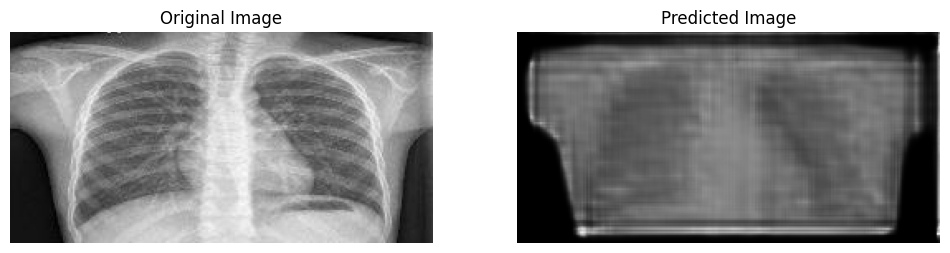

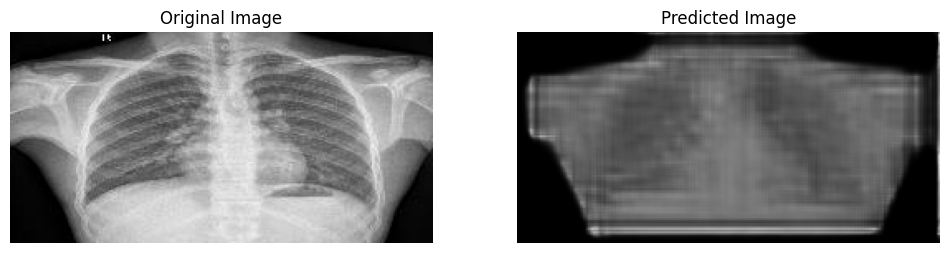

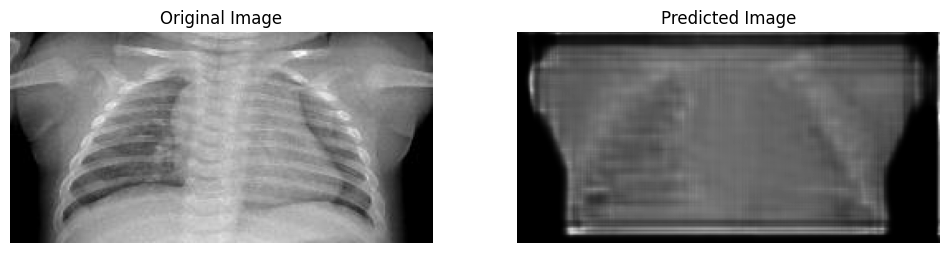

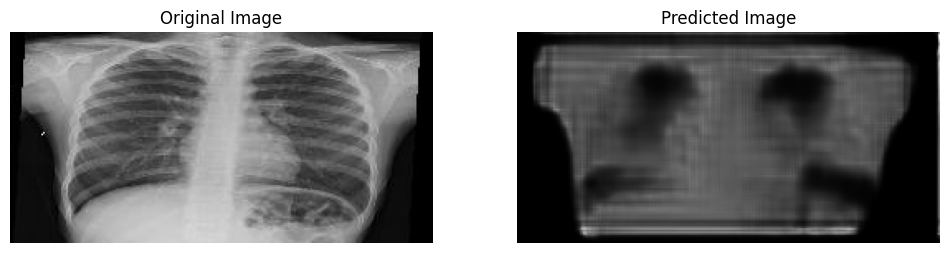

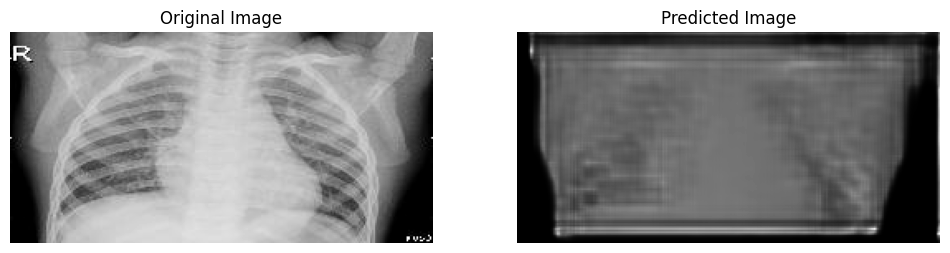

In [9]:
# num of images to plot
batch_size = 5

original_path = "./Data_processed/test/NORMAL/"
dataset = autoencoder.create_dataset([original_path], batch_size=batch_size, shuffle=False)

# loop: takes one batch of images from the tensorflow dataset, predict (compress) and plot against the original
# obs: img_batch is a tensorflow 'tensor'; like a np array with dimensions [batch_size, h, w, c]
for img_batch, _ in dataset.take(1):
    compressed_batch = autoencoder.predict(img_batch) # compressed_batch is numpy array with dimensions [batch_size, h, w, c]

    for orig_img, comp_img in zip(img_batch.numpy(), compressed_batch):
        # Display the original and predicted images side by side
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))
        
        axes[0].imshow(orig_img.squeeze(), cmap='gray')
        axes[0].set_title('Original Image')
        axes[0].axis('off')
        
        axes[1].imshow(comp_img.squeeze(), cmap='gray')
        axes[1].set_title('Predicted Image')
        axes[1].axis('off')
        
        plt.show()


### 2.2) Training - separating by class

Create groups of folders for each category

In [14]:
processed_base_path = "./Data_processed"
image_types = ['COVID19', 'NORMAL', 'PNEUMONIA', 'TURBERCULOSIS']

folders_train = {}
folders_test = {}
folders_val = {}

for ty in image_types:
  folders_train[ty] = f"./{processed_base_path}/train/{ty}/"
  folders_test[ty] = f"./{processed_base_path}/test/{ty}/"
  folders_val[ty] = f"./{processed_base_path}/val/{ty}/"

Instantiate the autoencoder, train each model separately and save

In [15]:
# paramters
height = 128
width = 256
batch_size = 32
epochs = 20
save_base_path = f"./trained_models/autoenconder/"

for ty in image_types:
    # instantiate autoencode
    autoencoder = ae.Autoencoder((height, width, 1))

    # define the network to use (convolutional)
    autoencoder.set_convolutional_network()

    # compile the autoencoder model
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

    # create train and test tensorflow datasets
    dataset_train = autoencoder.create_dataset([folders_train[ty], folders_val[ty]], resize=False, batch_size=batch_size, shuffle=True)
    dataset_test = autoencoder.create_dataset([folders_test[ty]], resize=False, batch_size=batch_size, shuffle=False)

    # fit the model
    model_save_path = f"{save_base_path}{ty}_dim_{height}_{width}/"
    autoencoder.train(dataset_train, dataset_test, epochs=epochs)


Epoch 1/20
15/15 [==============================] - 8s 547ms/step - loss: 0.2612 - val_loss: 0.0313
Epoch 2/20
15/15 [==============================] - 8s 523ms/step - loss: 0.0323 - val_loss: 0.0313
Epoch 3/20
15/15 [==============================] - 8s 521ms/step - loss: 0.0323 - val_loss: 0.0313
Epoch 4/20
15/15 [==============================] - 8s 522ms/step - loss: 0.0323 - val_loss: 0.0313
Epoch 5/20
15/15 [==============================] - 8s 524ms/step - loss: 0.0323 - val_loss: 0.0313
Epoch 6/20
15/15 [==============================] - 8s 523ms/step - loss: 0.0323 - val_loss: 0.0313
Epoch 7/20
15/15 [==============================] - 8s 523ms/step - loss: 0.0323 - val_loss: 0.0313
Epoch 8/20
15/15 [==============================] - 8s 523ms/step - loss: 0.0323 - val_loss: 0.0313
Epoch 9/20
15/15 [==============================] - 8s 524ms/step - loss: 0.0323 - val_loss: 0.0313
Epoch 10/20
15/15 [==============================] - 8s 524ms/step - loss: 0.0323 - val_loss: 0.0313

# 3) Compress images

Load one of the models

In [16]:
# model_path = f"./trained_models/autoencoder_{height}_{width}_epoch={epochs}_loss={loss}_batch={batch_size}_ty={ty}_lr={lr}/"
model_path = "./trained_models/autoencoder_128_256_epoch=20_loss=binary_crossentropy_batch=32_ty=1_lr=0.001"

autoencoder = ae.load_model(model_path)

Use loaded model to compression / prediction

In [17]:
batch_size = 32
# folders containing original images
processed_base_path = './Data_processed'
base_paths = {
    "train": f"{processed_base_path}/train/",
    "test":  f"{processed_base_path}/test/",
    "val": f"{processed_base_path}/val/",
}
folders = {k:u.get_subfolders(v) for (k,v) in base_paths.items()} 
# eg: folders["train"] = "[./Data/train/COVID19, ./Data/train/NORMAL, ...]"

# base path to save compressed images
base_path  = "./Data_compressed/"

# Predict using the autoencoder and save results to disk
for train_test_val, orig_folders in folders.items():
    dataset = autoencoder.create_dataset(orig_folders, resize=False, batch_size=batch_size, shuffle=False) 
    autoencoder.compress_and_save(dataset, f"{base_path}{train_test_val}/")

1/1 [==============================] - 0s 34ms/step


# 4) Visualization

Load one of the models

In [22]:
# model_path = f"./trained_models/autoencoder_{height}_{width}_epoch={epochs}_loss={loss}_batch={batch_size}_ty={ty}_lr={lr}/"
model_path = "./trained_models/autoencoder_128_256_epoch=20_loss=binary_crossentropy_batch=32_ty=1_lr=0.001"
autoencoder = ae.load_model(model_path)

Visualize model structure

In [23]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define the encoder part of the model
encoder = tf.keras.Sequential([
    layers.Input(shape=(128, 256, 1)),  # Replace with your `self.img_shape`
    layers.Conv2D(32, (7, 7), padding='same'),
    layers.BatchNormalization(),
    layers.LeakyReLU(alpha=0.01),
    layers.MaxPooling2D((2, 2), padding='same'),

    layers.Conv2D(64, (3, 3), padding='same'),
    layers.BatchNormalization(),
    layers.LeakyReLU(alpha=0.01),
    layers.MaxPooling2D((2, 2), padding='same'),

    layers.Conv2D(128, (3, 3), padding='same'),
    layers.BatchNormalization(),
    layers.LeakyReLU(alpha=0.01),
    layers.MaxPooling2D((2, 2), padding='same'),
])

# Assuming you also have a decoder structure defined, you would then do:
# autoencoder = models.Model(inputs=encoder.inputs, outputs=decoder(encoder.output))

# For the sake of example, let's assume the decoder is a mirror of the encoder:
decoder = tf.keras.Sequential([
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.UpSampling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.UpSampling2D((2, 2)),
    layers.Conv2D(32, (7, 7), activation='relu', padding='same'),
    layers.UpSampling2D((2, 2)),
    layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same'),
])

# Combine encoder and decoder into one model
autoenc = models.Model(inputs=encoder.input, outputs=decoder(encoder.output))

# Now you can visualize the model
tf.keras.utils.plot_model(autoenc, to_file='autoencoder_model.png', show_shapes=True, show_layer_names=True)
autoenc.summary()


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 128, 256, 1)]     0         
                                                                 
 conv2d_105 (Conv2D)         (None, 128, 256, 32)      1600      
                                                                 
 batch_normalization_33 (Ba  (None, 128, 256, 32)      128       
 tchNormalization)                                               
                                                                 
 leaky_re_lu_81 (LeakyReLU)  (None, 128, 256, 32)      0         
                                                                 
 max_pooling2d_45 (MaxPooli  (None, 64, 128, 32)       0         
 ng2D)                                    

Visualize compression

Original vs Predicted: NORMAL
1/1 [==============================] - 0s 94ms/step


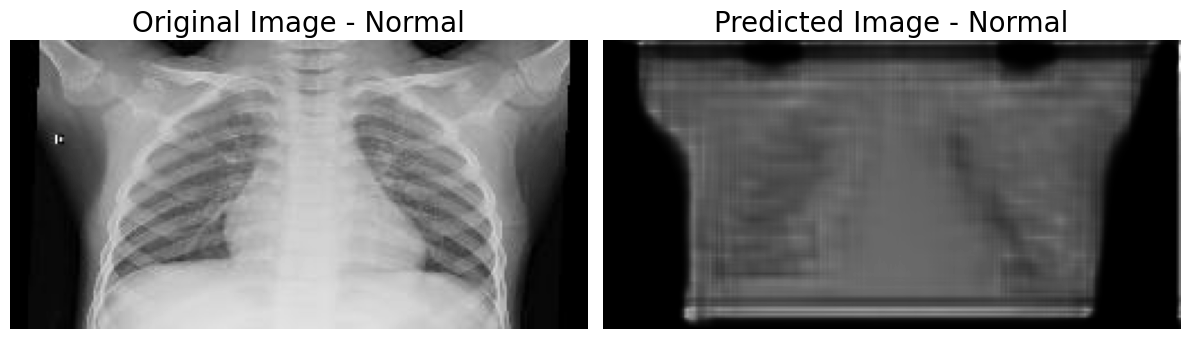

Original vs Predicted: COVID19
1/1 [==============================] - 0s 14ms/step


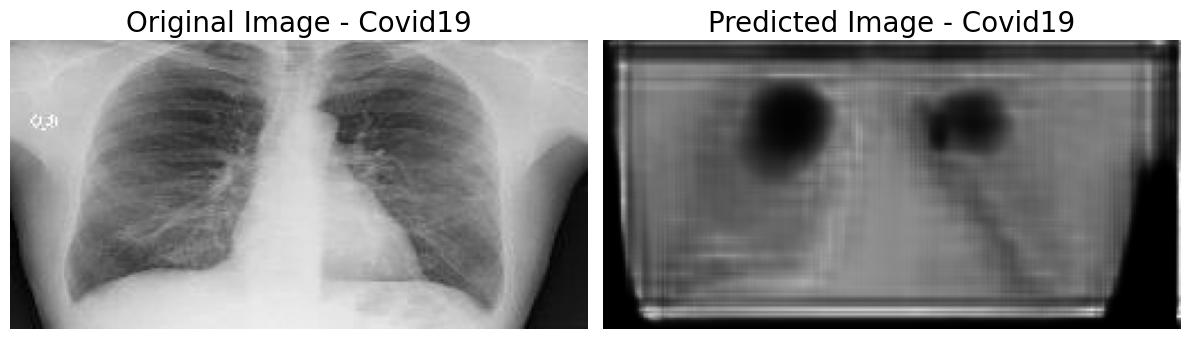

Original vs Predicted: PNEUMONIA
1/1 [==============================] - 0s 14ms/step


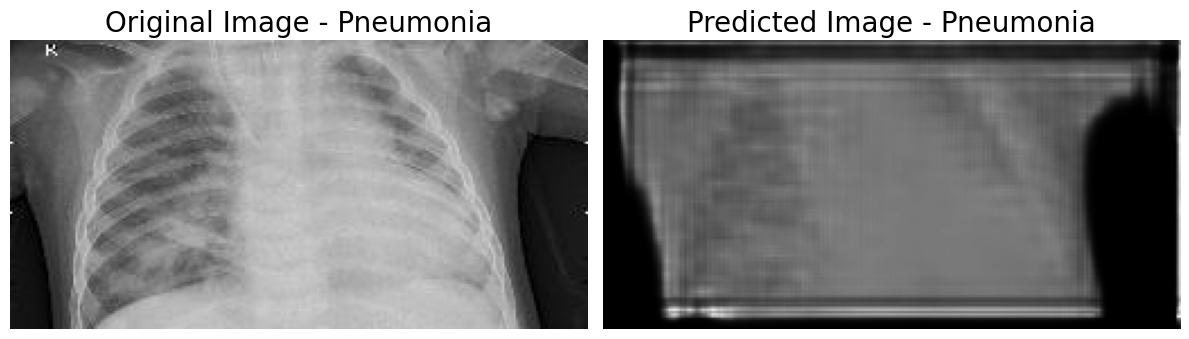

Original vs Predicted: TURBERCULOSIS
1/1 [==============================] - 0s 13ms/step


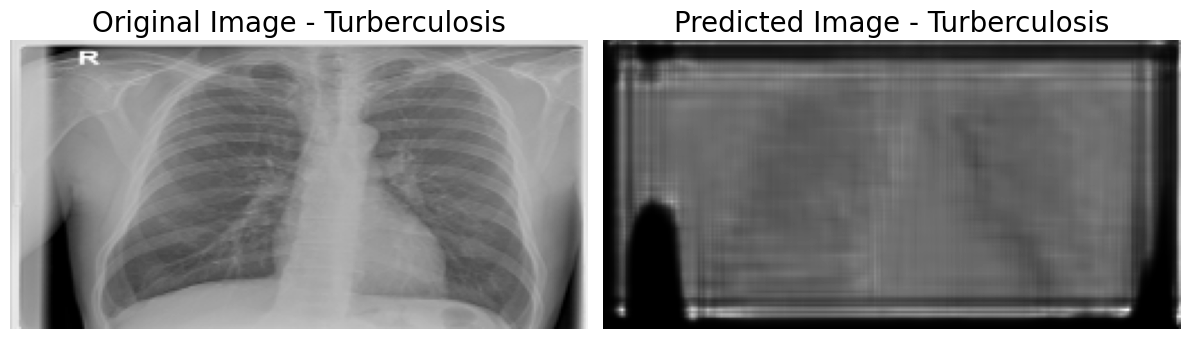

In [24]:
# path to the folder of images to use as input to predict
original_base_path = f"./Data_processed/test/"

# classes to visualize
folders = ["NORMAL", "COVID19", "PNEUMONIA", "TURBERCULOSIS"]

# num of images to visualize for each class
batch_size = 1

# save visualizations?
save = False
save_base_path = f"./assets/images/"

for folder in folders:
    original_path = f"{original_base_path}/{folder}/"
    dataset = autoencoder.create_dataset([original_path], batch_size=batch_size, shuffle=True)

    print(f"Original vs Predicted: {folder}")
    # img_batch is a tensorflow tensor; like a numpy array with dimensions[batch_size, height, width, channels]
    for img_batch, _ in dataset.take(1):
        compressed_batch = autoencoder.predict(img_batch)
        
        for orig_img, comp_img in zip(img_batch.numpy(), compressed_batch):
            # print(f"Original Image Value Range: Min: {orig_img.min()}, Max: {orig_img.max()}")
            # print(f"Predicted Image Value Range: Min: {comp_img.min()}, Max: {comp_img.max()}")

            # Display the original and predicted images side by side
            fig, axes = plt.subplots(1, 2, figsize=(12, 6))
            
            axes[0].imshow(orig_img.squeeze(), cmap='gray')
            axes[0].set_title(f'Original Image - {folder.title()}', fontsize=20)
            axes[0].axis('off')
            
            axes[1].imshow(comp_img.squeeze(), cmap='gray')
            axes[1].set_title(f'Predicted Image - {folder.title()}', fontsize=20)
            axes[1].axis('off')
            plt.tight_layout()
            
            if save:
                plt.savefig(f'{save_base_path}/atc-orig-vs-predict-{folder}.png', bbox_inches='tight')

            plt.show()

